# Demo redes Recursivas (LSTM o GRU) para clasificar (atributo clase discreto), estimar (atributo clase continuo)  o generar (atributo clase texto) usando como entrada Texto
Basado en

https://keras.io/guides/functional_api/

https://keras.io/examples/nlp/text_classification_from_scratch/#build-a-model

https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=es-419


Nota: la fuente de datos para datos <FilmAffinity.csv> es https://www.kaggle.com/code/ricardomoya/an-lisis-de-sentimientos-clasificaci-n-de-textos/data pero se corrigieron unos detalles que tenía.

In [ ]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

import unicodedata
import copy
import random
import os
import csv

print("Librerías cargadas")

Librerías cargadas


# Datos / Texto:

In [ ]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/texto/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
#@title Cargar datos

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'FilmAffinity.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = '\\|\\|' #@param {type:"string"}

## selección de los parámetros


def checkValidCharacter(str):
  if len(str) == 0:
    return False
  for ch in str:
    # controla cada caracter
    if (ch != "\n") and \
       (unicodedata.category(ch) in {'Cc', 'Cf', 'Cn', 'Co', 'Cs'}):
      return False
    # nota: ver categorias en https://www.fileformat.info/info/unicode/category/index.htm
  return True

def limpiarTexto(texto_ori):
  auxList = []
  t = list( texto_ori.strip() )
  for c in t:
    if checkValidCharacter(c):
      auxList.append( c )
  return "".join(auxList)


# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""


# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# inicializa valores
Xori = None
X = None
Y = None
nombre_atributos_entrada = []
texto_cargado = None

# determina tipo de archivo a usar (si es de Texto o Datos)
if ".csv" in archivo_datos.lower():
    # se condidera un archivo de datos
    esArchivoDatos = True

    # función auxiliara para que no ejecute UI cada vez
    def hacerNada():
      return

    # se define esta función para que se ocupe de aplicar la configuración
    def on_buttonAplicar_clicked(b):
      print("")
      funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

    # aplica configuración de datos
    def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
      global Y, Xori, nombre_clases, nombre_atributos_entrada

      if (attClase is None) or (attClase =="") or\
        (att_entrada is None) or (att_entrada ==""):
        return

      # si el atributo clase está como de entrada, lo saca (no tiene sentido)
      att_entrada = list(att_entrada)
      if attClase in att_entrada:
        print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
        att_entrada.remove( attClase )

      if (att_entrada == "") or (len(att_entrada)==0):
        print("No se han definido atributos de entrada!")
        return

      # guarda configuración
      nombre_clases = nomClases
      nombre_atributos_entrada = att_entrada

        # genera los datos solo con los atributos seleccionados
      Y = np.array(df[attClase])
      Xori = np.array(df[att_entrada])

      # muestra resultados
      print("\n> Atributos entrada: ", att_entrada)
      print("\t X: ", Xori.shape)

      if (nombre_clases is None) or (nombre_clases==""):
        print("\n> Atributo clase: ", attClase)
      else:
        print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
      print("\t Y: ", Y.shape)

    ## aplicación de los parámetros elegidos

    # Carga los datos del CSV y muestra los primeros
    df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
    print("Archivo de datos ", archivo_datos, " cargado")

    print("\n> Cabecera: ")
    print(df.head())
    print("\n> Características: ")
    print(df.describe())
    print("\n")

    # intenta cargar configuración asociada a los datos
    # trata de obtener la configuración del archivo asociado
    atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

    # muestra interface para cargar configuración

    # auxiliar para que muestre bien la descripción
    style_3D = {'description_width': 'initial'}

    tit = widgets.Label("Ajuste para configuración de los Datos: ")

    # prepara combo para determinar atributo clase
    selecc_atributos = [ ]
    selecc_atributos.extend( df.columns.values.tolist() )
    if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
      att_selecc_defecto = 0
    else:
      att_selecc_defecto = selecc_atributos.index(atributo_clase)
    combo_att_clase = widgets.Dropdown(
        options = selecc_atributos,
        value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
        description = 'Atributo clase:',
        style=style_3D,
        disabled = False,
    )
    # prepara campo para ingresar nombre clases (toma por defecto de config)
    texto_nomClases = widgets.Text(
        value=nombre_clases,
        placeholder='Ingrese nombre clases (si corresponde) separados por comas',
        description='Nombre clases:',
        style=style_3D,
        disabled=False
    )

    combo_att_entrada = widgets.SelectMultiple(
        options=selecc_atributos,
        value=selecc_atributos,
        #rows=10,
        description='Atributos de entrada:',
        style=style_3D,
        disabled=False
    )

    # prepara botón y grilla con objetos
    btnAplicar = widgets.Button(
        description='Aplicar'
    )
    configDatos_ui = widgets.GridBox(
          children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
          layout=Layout(width='100%')  )
    btnAplicar.on_click(on_buttonAplicar_clicked)

    # clear_output()
    out_config = widgets.interactive_output(hacerNada, {})
    display(configDatos_ui)

    # ejecuta para que muestre
    on_buttonAplicar_clicked(btnAplicar)

else:
    # se condidera un archivo de texto
    esArchivoDatos = False

    X = None
    Y = None

    # levanta el archivo de texto del Drive para procesar
    texto_cargado = open("".join(path + archivo_datos), 'rb').read().decode(encoding='utf-8', errors='ignore')
    print("Archivo de texto ", archivo_datos, " cargado")

    # saca caracteres en blanco al principio y fin
    # y caracteres de control especiales
    print("> Se limpian caracteres especiales de control")
    texto_cargado = limpiarTexto(texto_cargado)

    print("\n> Características: ")
    print (' -- Tamaño total del texto: {} caracteres'.format(len(texto_cargado)))

    # muestra los primeros 250 caracteres del texto
    print("\n -- Ejemplo: \n", texto_cargado[:250])

Archivo de datos  FilmAffinity.csv  cargado

> Cabecera: 
               film_name   gender  film_avg_rate  review_rate  \
0  Ocho apellidos vascos  Comedia            6.0            3   
1  Ocho apellidos vascos  Comedia            6.0            2   
2  Ocho apellidos vascos  Comedia            6.0            2   
3  Ocho apellidos vascos  Comedia            6.0            2   
4  Ocho apellidos vascos  Comedia            6.0            2   

                                        review_title  \
0     OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO   
1                                     El perro verde   
2  Si no eres de comer mierda... no te comas esta...   
3                                    Aida: The movie   
4               UN HOMBRE SOLO (Julio Iglesias 1987)   

                                         review_text  
0  La mayor virtud de esta película es su existen...  
1  No soy un experto cinéfilo, pero pocas veces m...  
2  Si no eres un incondicional del humor estilo T

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo film_name como de entrada dado que es clase.

> Atributos entrada:  ['gender', 'film_avg_rate', 'review_rate', 'review_title', 'review_text']
	 X:  (8603, 5)

> Atributo clase:  film_name
	 Y:  (8603,)


In [ ]:
#@title Generar datos de entrada como Texto

incluir_nombre_atributos = False #@param {type:"boolean"}
marcar_separador_atributos = "#!# " #@param {type:"string"}

def prepararDatosEntradaTexto(Xori):
    if Xori is None:
      raise(Exception("Falta definir configuración de la carga de datos!"))

    print("> Uniendo atributos X en campo de texto de Datos: ")

    print("\n Datos X originales: ", Xori.shape)
    print(Xori[:3])

    X = []
    for xEj in Xori:
      auxX = ""
      for atEj, nomAt in zip(xEj, nombre_atributos_entrada):
        if (auxX != ""):
          auxX = auxX + " " + marcar_separador_atributos
        if incluir_nombre_atributos:
          auxX = auxX + nomAt + " "
        auxX = auxX + str(atEj)
      X.append( limpiarTexto(auxX) )
    X = np.array( X )
    print("\n Nuevo X: ", X.shape)
    print(X[:3])
    return X

if esArchivoDatos:
    # para archivo de datos
    X = prepararDatosEntradaTexto(Xori)
else:
    # para archivo de texto
    print("No se necesita ejecutar porque se usa archivo de texto.")

> Uniendo atributos X en campo de texto de Datos: 

 Datos X originales:  (8603, 5)
[['Comedia' 6.0 3 'OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO'
  'La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho de nuestra madurez como nación (pese a quien pese). Bueno, corrijo: el hecho de que podamos jugar y hacer mofa y befa de los tópicos sobre los vascos y el nacionalismo vasco, sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho del grado de normalización de ciertas cuestiones que antes eran llagas abiertas siempre dispuestas a sangrar. Y hago esta corrección, porque los andaluces han sido motivo de guasa siempre y nunca ha pasado nada.Por esto mismo, el planteamiento de "Ocho Apellidos Vascos" es valiente, es oportuno y es oportunista. Seguramente sea esa una de las principales razones

In [ ]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "texto - GENERACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION", "texto - GENERACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   80#@param {type:"integer"}

# inicializa
x_train, x_test, y_train, y_test = None, None, None, None

if esArchivoDatos:
    # para archivo de datos

    if X is None or Y is None:
      raise(Exception("Falta definir configuración de la carga de datos!"))

    # determina la proporción a usar para entrenar y probar
    if proporcion_porcentaje_datos_entrenamiento>100:
      propTrain = 1
    elif proporcion_porcentaje_datos_entrenamiento<1:
      propTrain = 0.1
    else:
      propTrain = proporcion_porcentaje_datos_entrenamiento/100

    # determina si es problema de clasificación o estimación o generación de texto
    if (considerar_atributo_clase[0].upper() == "T"):
      # generación de texto
      tipoProblemaAplicar = "T"
    elif (considerar_atributo_clase[0].upper() == "D"):
      # clasificación
      tipoProblemaAplicar = "C"
    else:
      # estimación
      tipoProblemaAplicar = "E"

    # separa al azar usando muestreo con proporción indicada
    if (tipoProblemaAplicar == "C"):
      # intenta hacer muestreo estatificado
      try:
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)
      except ValueError:
        print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
        # hace muestreo simple
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))
    else:
      # hace muestreo simple
      x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))

    # inicializa
    y_trainEnc = []
    y_testEnc =  []


    # hace conversión para evitar error al procesar datos
    # ver https://github.com/tensorflow/tensorflow/issues/65237
    x_train = x_train.astype(object)
    x_test = x_test.astype(object)

    CLASES = []
    if (tipoProblemaAplicar == "C"):
      print("> se considera problema de CLASIFICACIÓN \n")

      # define nombre de clases
      if (nombre_clases == "") or (nombre_clases == "-"):
          # toma los valores de clase orginales del archivo
          print(Y[0])
          if str(Y[0]).replace(".","").isnumeric():
            # Y son numeros
            for val in range(int(np.max(Y))+1):
              CLASES.append( "clase {:>3}".format(val) )
          else:
              # Y no son números
              CLASES = list(set(Y))
              CLASES.sort()
              # cambia valores para que sean enteros
              y_train = [ CLASES.index(y) for y in y_train]
              y_test = [ CLASES.index(y) for y in y_test]
      else:
          # toma configuración de nombre de clases
          for val in nombre_clases.split(','):
            CLASES.append( val )

      # genera salida codificada para softMax
      y_trainEnc = to_categorical(y_train)
      y_testEnc = to_categorical(y_test)

      # muestra resultados
      print("> Definición de CLASES: ")
      print(" - dictMapeo (", len(CLASES), "): ", CLASES)

    elif (tipoProblemaAplicar == "T"):
      print("> se considera problema de GENERACIÓN DE TEXTO \n")

    else: # (tipoProblemaAplicar == "E"):
      print("> se considera problema de ESTIMACIÓN \n")

    print("\n> Para Entrenamiento: ")
    print(" - x_train (cant): ", x_train.shape)
    print(" - y_train (cant): ", len(y_train))
    if (tipoProblemaAplicar == "C"):
      for i in range(len(CLASES)):
        cant = 0
        for y in y_train:
          if i == int(y): cant = cant + 1
        print("    ", CLASES[i], "[", i, "]:", cant)

    print("\n Para Prueba: ")
    print(" - x_test (cant): ", x_test.shape)
    print(" - y_test (cant): ", len(y_test))
    if (tipoProblemaAplicar == "C"):
      for i in range(len(CLASES)):
        cant = 0
        for y in y_test:
          if i == int(y): cant = cant + 1
        print("    ", CLASES[i], "[", i, "]:", cant)

else:
    # para archivo de texto
    tipoProblemaAplicar = "T"
    print("Al usar Archivo de Texto: ")
    print("-- se considera problema de GENERACIÓN DE TEXTO")
    print("-- se utiliza el texto completo para entrenamiento")
    print("-- se divide el texto completo usando saltos de líneas (\\n)")

    # se divide el texto usando salto de líneas
    y_train = texto_cargado.split("\n")
    print("\n> Para Entrenamiento: ")
    print(" - Frases (cant): ", len(y_train))

    if len(y_train)>3:
      print("\nEjemplos: ")
      for i in range(3):
        print("\t", y_train[i])



> se considera problema de GENERACIÓN DE TEXTO 


> Para Entrenamiento: 
 - x_train (cant):  (6882,)
 - y_train (cant):  6882

 Para Prueba: 
 - x_test (cant):  (1721,)
 - y_test (cant):  1721


In [ ]:
#@title Definir Encoding & Embeding del Texto

#@markdown Parámetros para Encoding:
tipo_vocabuario = "caracteres" #@param ["palabras", "caracteres"]
tamaño_maximo_vocabulario = 2000 #@param {type:"integer"}
tamaño_maximo_frase_texto = 100 #@param {type:"integer"}
estandarizar_usar_todo_minusculas = True #@param {type:"boolean"}
estandarizar_sacar_puntuacion = True #@param {type:"boolean"}

#@markdown Parámetros para Embeding:
tamaño_dimensiones_vectores = 64 #@param {type:"integer"}

# función auxiliar para codificar texto
def codificarTexto(encoder, texto):
  return encoder(texto).numpy()

def separarTexto(texto , separadorTokens):
  if separadorTokens=="":
    splitText = list(texto)
  else:
    splitText = texto.split(separadorTokens)
  return splitText

# muestra texto codificado
def mostrarCodificarTexto(encoder, texto, separadorTokens=" "):
  textoCodif = codificarTexto(encoder, texto)
  print("Texto: ", texto)
  splitText = separarTexto(texto, separadorTokens)
  print("Vector[" + str(len(splitText)) +  "]: ", splitText)
  print("Codif[" + str(len(textoCodif)) + "]: ", textoCodif)
  return textoCodif

# rellena vector con valores ceros
def rellenar_vector(vec, nshape):
  # hace una copia del vector
  aux = copy.deepcopy(vec)
  # le cambia el tamaño
  aux.resize(nshape, refcheck=False)
  # lo devuelve
  return aux

# aplica configuración
if tamaño_maximo_vocabulario < 10:
  tamaño_maximo_vocabulario = 10

if tamaño_maximo_frase_texto < 10:
  tamaño_maximo_frase_texto = 10

if tamaño_dimensiones_vectores < 10:
  tamaño_dimensiones_vectores = 10

if tipo_vocabuario == "palabras":
  split_type = "whitespace"
  separadorTokens = " "
elif tipo_vocabuario == "caracteres":
  split_type = "character"
  separadorTokens = ""
else:
  # no se usa porque no hace ninguna separación
  split_type = None
  separadorTokens = ""

if estandarizar_usar_todo_minusculas and estandarizar_sacar_puntuacion:
  standardize_type = "lower_and_strip_punctuation"
elif estandarizar_usar_todo_minusculas:
  standardize_type = "lower"
elif estandarizar_sacar_puntuacion:
  standardize_type = "strip_punctuation"
else:
  standardize_type = None

if esArchivoDatos:
    # para archivo de datos solamente

    # prepara para manejar datos (usados por todos)
    print("\n-- Crear Encoder para datos.")

    # crea codificador
    x_encoderLay = tf.keras.layers.TextVectorization(
        max_tokens = tamaño_maximo_vocabulario,
        standardize = standardize_type,
        split = split_type,
        output_mode='int',
        output_sequence_length = tamaño_maximo_frase_texto,
        name = "encoding-Data")

    # lo inicializa usando los textos de entrada para entrenamiento
    x_encoderLay.adapt(x_train)

    # obtiene el vocabulario
    x_vocab = np.array(x_encoderLay.get_vocabulary())
    ##print( x_vocab[:20] )

    # determina el tamaño del vocabulario
    x_vocab_size = len(x_vocab)
    print("\t tamaño vocabulario de datos = ", x_vocab_size)


if (tipoProblemaAplicar == "T"):

    # prepara para generación de texto (solo datos Y)
    # se usa con archivos de datos o de texto

    # determina tags especiales (constantes)
    # notar que no se peuden usar símbolos especiales porque luego se filtran
    if tipo_vocabuario == "palabras":
        tag_gentext_begin = "ästartä"
        tag_gentext_end = "üendü"
    else: # tipo_vocabuario == "caracter":
        tag_gentext_begin = "ä"
        tag_gentext_end = "ü"

    # crea codificador
    print("\n-- Crear Encoder para texto.")
    y_encoderLay = tf.keras.layers.TextVectorization(
        max_tokens = tamaño_maximo_vocabulario,
        standardize = standardize_type,
        split = split_type,
        output_mode = "int",
        output_sequence_length = tamaño_maximo_frase_texto,
        name = "encoding-Text")

    # lo inicializa usando los textos de entrada y salida para entrenamiento
    auxYcompleto = [tag_gentext_begin, tag_gentext_end]
    auxYcompleto.extend( y_train )
    if esArchivoDatos:
        # para archivo de datos
        auxYcompleto.extend( y_test )
    y_encoderLay.adapt( auxYcompleto )

    # obtiene el vocabulario
    y_vocab = np.array(y_encoderLay.get_vocabulary())
    ##print( y_vocab[:20] )

    # determina el tamaño del vocabulario
    y_vocab_size = len( y_vocab )
    print("\t tamaño vocabulario de texto = ", y_vocab_size)

    # determina codificación de tags
    codif_gentext_begin = y_encoderLay(tag_gentext_begin).numpy()[0]
    codif_gentext_end = y_encoderLay(tag_gentext_end).numpy()[0]
    print("\n-- Tags especiales: ")
    print("\t comienzo = " + tag_gentext_begin + " (" + str(codif_gentext_begin) + ")")
    print("\t fin = " + tag_gentext_end + " (" + str(codif_gentext_end) + ")")

    if esArchivoDatos:
        # para archivo de datos
        print("\n-- Preparando múltiples entradas y salida para generar texto.")
    else:
        # para archivo de texto
        print("\n-- Preparando entrada y salida para generar texto.")

    inputs_x_train = [] # entrada para datos
    inputs_prevText_train = [] # entrada para texto previo (o begin)
    y_trainEnc = [] # salida de texto (un elemento por vez)
    for i in range(len(y_train)):
      if esArchivoDatos:
          # determina los datos
          x = x_train[i]
      # determina texto
      y = y_train[i]
      # si la salida está definida
      if len(y) > 1:
        # codifica la salida (le agrega los tags para marcar comienzo y fin)
        yCodif = codificarTexto(y_encoderLay, " ".join([tag_gentext_begin, y, tag_gentext_end]) )
        yCodifShape = yCodif.shape
        # va tomando por partes
        if esArchivoDatos:
          # como tiene datos complementarios, puede arrancar con el tag_gentext_begin
          jIni = 1
        else:
          # como no tiene datos complementarios, debe tener además de tag_gentext_begin alguna palabra
          # sino no sabe como arrancar
          jIni = 2
        for j in range(jIni, len(yCodif)):
            if esArchivoDatos:
              # determina entrada de datos (copiada igual por cada una de texto previo)
              inputs_x_train.append( x )
            # determina entrada de texto previo (competa con ceros para tener largo fijo)
            inputs_prevText_train.append( rellenar_vector(yCodif[:j], yCodifShape) )
            # determina salida texto (un lemento)
            y_trainEnc.append( yCodif[j] )
            # si llego al tag de END, termina
            if (yCodif[j] == codif_gentext_end) or (yCodif[j] == tag_gentext_end):
              break

    # convierte a arrays
    if esArchivoDatos:
        inputs_x_train = np.array( inputs_x_train )
        # hace conversión para evitar error al procesar datos
        # ver https://github.com/tensorflow/tensorflow/issues/65237
        inputs_x_train = inputs_x_train.astype(object)

    inputs_prevText_train = np.array( inputs_prevText_train )
    y_trainEnc = np.array( y_trainEnc )

    # muestra formas
    if esArchivoDatos:
        print("\tinputs_x_train: ", inputs_x_train.shape)
    print("\tinputs_prevText_train: ", inputs_prevText_train.shape)
    print("\ty_trainEnc: ", y_trainEnc.shape)

    print("\n> Ejemplos de codificación: \n")
    for _ in range(3):
      posAzar = random.randint(1, len(inputs_prevText_train)) - 1
      if esArchivoDatos:
          print("-INPUT DATOS: ")
          mostrarCodificarTexto(x_encoderLay,  inputs_x_train[posAzar], separadorTokens)
      auxT = ""
      auxV = inputs_prevText_train[posAzar]
      for v in auxV:
        auxT = auxT + separadorTokens + y_vocab[v]
      print("-INPUT TEXTO: ", auxT, " \n--> ",  inputs_prevText_train[posAzar] )
      auxV = y_trainEnc[posAzar]
      print("-OUTPUT:      ", y_vocab[auxV], " --> [", auxV, "]")
      print("")

else:
    # muesta ejemplos sólo datos
    print("\n> Ejemplos de codificación: \n")
    for _ in range(3):
      posAzar = random.randint(1, len(x_train)) - 1
      mostrarCodificarTexto(x_encoderLay,  x_train[posAzar], separadorTokens)
      print("")




-- Crear Encoder para datos.
	 tamaño vocabulario de datos =  97

-- Crear Encoder para texto.
	 tamaño vocabulario de texto =  39

-- Tags especiales: 
	 comienzo = ä (38)
	 fin = ü (37)

-- Preparando múltiples entradas y salida para generar texto.
	inputs_x_train:  (117741,)
	inputs_prevText_train:  (117741, 100)
	y_trainEnc:  (117741,)

> Ejemplos de codificación: 

-INPUT DATOS: 
Texto:  Comedia #!# 5.5 #!# 8 #!# Está bien esta cama... #!# Primero: La comento sin comprararla con la primera. "El otro lado de la cama" la he visto dos veces en el cine, y me gustó mucho, pero procuré ver ésta sin poner el listón muy alto.Me ha parecido bastante buena. Los diálogos "cachondos" (en todos los sentidos), las canciones rompen el ritmo (en el buen sentido), y los actores, sobresalientes.Fui al cine con la idea de pasar un rato agradable, y esta película no me defraudó, más bien al contrario.
Vector[503]:  ['C', 'o', 'm', 'e', 'd', 'i', 'a', ' ', '#', '!', '#', ' ', '5', '.', '5', ' ', '#',

# Modelo:

Modelo creado con  10  capas:


Model: "GenText_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_Data (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoding-Data             │ (None, 100)            │              0 │ input_Data[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_prevText            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_Data            │ (None, 100, 64)        │          6,208 │ encoding-Data[1][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_prevText        │ (None, 100, 64)        │        128,000 │ input_prevText[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MergeInputs (Concatenate) │ (None, 100, 128)       │              0 │ embedding_Data[0][0],  │
│                           │                        │                │ embedding_prevText[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bdirecc (Bidirectional)   │ (None, 300)            │        252,000 │ MergeInputs[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lineal_1 (Dense)          │ (None, 100)            │         30,100 │ bdirecc[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d_2 (Dropout)             │ (None, 100)            │              0 │ lineal_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputText (Dense)        │ (None, 39)             │          3,939 │ d_2[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 420,247 (1.60 MB)

 Trainable params: 420,247 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

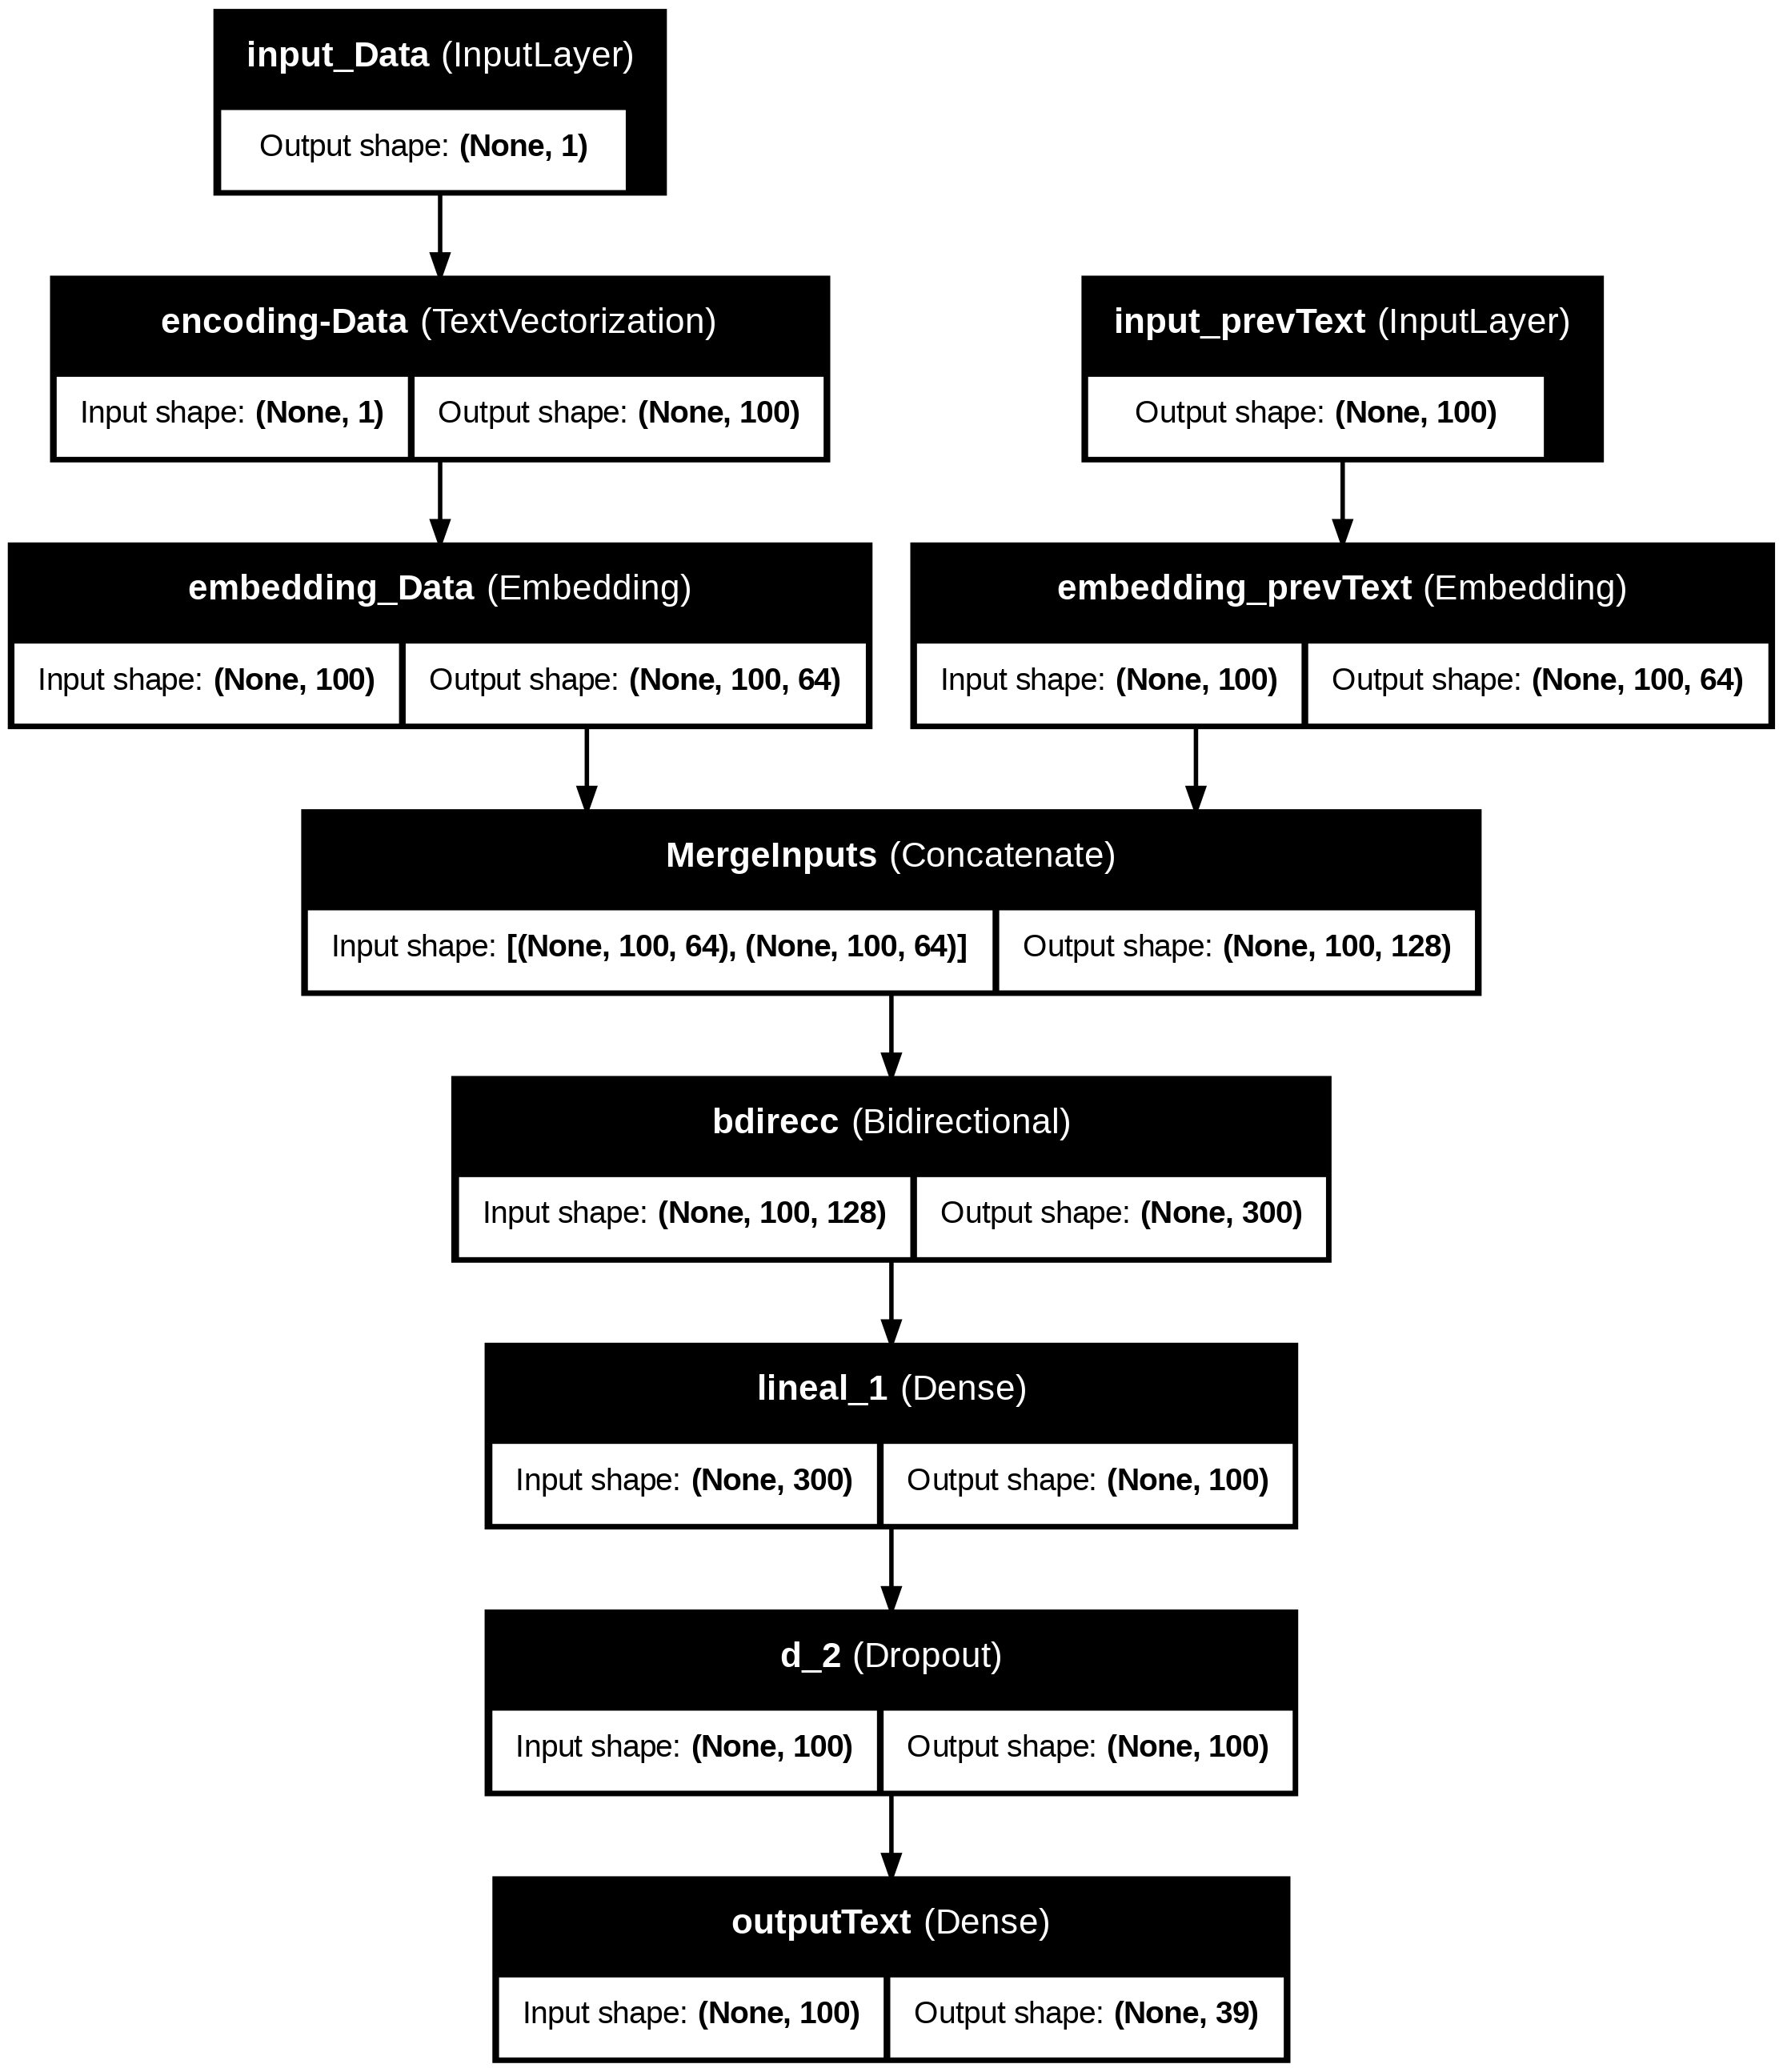

In [ ]:
#@title Establecer modelo

#@markdown ### Parámetros de las capas RNN:

rnn_tipo_red = "Bidirectional" #@param ["Simple", "Stacked", "Bidirectional", "Bidirectional Stacked"]
rnn_tipo_capa = "GRU" #@param ["LSTM", "GRU"]
rnn_cant_neuronas = 150 #@param {type: "integer"}
rnn_func_activation = "tanh" #@param ['relu', 'sigmoid', 'tanh']
rnn_porc_capa_DropOut = 0.2 #@param {type:"number"}

#@markdown ### Parámetros de las capas Lineales:
lineal_cant_neuronas_capas_ocultas = '100, D' #@param {type:"string"}
#@markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
lineal_porc_capa_DropOut = 0.4 #@param {type:"number"}

#@markdown ### Parámetros de la capa de Salida:
red_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.001 #@param {type: "number"}

## aplicación de los parámetros elegidos

if rnn_func_activation == "relu":
  print("-- recordar que al no usar rnn_func_activation con tanh puede ser que no se use GPU (ver requerimientos en https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)")

# chequea configuración de drop out
if lineal_porc_capa_DropOut <= 0:
  lineal_porc_capa_DropOut = 0.10
elif lineal_porc_capa_DropOut > 0.9:
    lineal_porc_capa_DropOut = 0.9
if rnn_porc_capa_DropOut <= 0:
  rnn_porc_capa_DropOut = 0.00
elif rnn_porc_capa_DropOut > 0.9:
    rnn_porc_capa_DropOut = 0.9

# cantidad de neuronas ocultas
hidden_layers = []
for val in lineal_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  if val == "D":
    hidden_layers.append( "DropOut" )
  elif val == "BN":
    hidden_layers.append( "BatchNormalization" )
  elif val.isnumeric():
    hidden_layers.append( val )
  else:
    print("Capa ", val, "descartada!")

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
if (tipoProblemaAplicar == "C"):
  tipo_output_softMax = (red_tipo_capa_salida[:7] == 'softmax')
else:
  tipo_output_softMax = False

if rnn_cant_neuronas < 5:
  rnn_cant_neuronas = 5

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente

if esArchivoDatos:
  # para archivo de datos

  # agrega capas de entrada y encoding  para datos de entrada
  x_inputLay = tf.keras.layers.Input(dtype=tf.string, shape=(1,), name="input_Data")
  #eachLay = x_inputLay
  eachLay = x_encoderLay(x_inputLay)

  # crea capa para embedding
  # que convierte las secuencias de índices codficadas
  # en secuencias de vectores usados para entrenar
  eachLay = tf.keras.layers.Embedding(
          input_dim = x_vocab_size,
          output_dim = tamaño_dimensiones_vectores,
          mask_zero = False,
          name = "embedding_Data",
          input_length=1)(eachLay)

if (tipoProblemaAplicar == "T"):
  # para archivo de datos o texto

  # agrega capas entrada y encoding  para generación de texto
###  y_inputLay = tf.keras.layers.Input(dtype=tf.string,(1,), name="input-Text")
###  eachLay_text = y_encoderLay(y_inputLay)

  y_inputLay = tf.keras.layers.Input(shape=inputs_prevText_train[0].shape,
                                     name="input_prevText")
  eachLay_text = y_inputLay

  # crea capa para embedding
  # que convierte las secuencias de índices codficadas
  # en secuencias de vectores usados para entrenar
  eachLay_text = tf.keras.layers.Embedding(
          input_dim = tamaño_maximo_vocabulario,
          output_dim = tamaño_dimensiones_vectores,
          mask_zero = False,
          name = "embedding_prevText")(eachLay_text)

  if esArchivoDatos:
    # solo si es archivo de datos
    # une los dos embeddings juntos para ser procesados por la red
    concatLay = tf.keras.layers.concatenate([eachLay, eachLay_text], name="MergeInputs")
    eachLay = concatLay

  else:
      # para archivo de texto
      eachLay = eachLay_text



# agrega capas RNN
# nota ojo que si se usa activation='relu' no utiliza GPU!
if rnn_tipo_red == "Simple":
  # una capa
  if rnn_tipo_capa == "LSTM":
    eachLay = tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="simple")(eachLay)
  else:
    eachLay = tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="simple")(eachLay)

elif rnn_tipo_red == "Stacked":
  # dos capas
  if rnn_tipo_capa == "LSTM":
    eachLay = tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, return_sequences=True, dropout=rnn_porc_capa_DropOut, name="stacked_1")(eachLay)
    eachLay = tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="stacked_2")(eachLay)
  else:
    eachLay = tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, return_sequences=True, dropout=rnn_porc_capa_DropOut, name="stacked_1")(eachLay)
    eachLay = tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="stacked_2")(eachLay)

elif rnn_tipo_red == "Bidirectional":
  # una capa bidireccional
  if rnn_tipo_capa == "LSTM":
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="LSTM"),  name="bdirecc")(eachLay)
  else:
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="GRU"), name="bdirecc")(eachLay)

elif rnn_tipo_red == "Bidirectional Stacked":
  # dos capa bidireccional
  if rnn_tipo_capa == "LSTM":
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, return_sequences=True, dropout=rnn_porc_capa_DropOut, name="LSTM_1"),  name="bdirecc_stacked_1")(eachLay)
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="LSTM_2"),  name="bdirecc_stacked_2")(eachLay)
  else:
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, return_sequences=True, dropout=rnn_porc_capa_DropOut, name="GRU_1"), name="bdirecc_stacked_1")(eachLay)
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="GRU_2"), name="bdirecc_stacked_2")(eachLay)

##else:
##  print("Tipo de red inválida: ", rnn_tipo_red, "!!!")

#if len(hidden_layers) > 0:
#  eachLay = tf.keras.layers.Flatten(name="flat")(eachLay)

# agrega capas lineales
auxName = 'lineal_'
auxId = 1
for val_hid in hidden_layers:

  if val_hid == "DropOut":
    auxlayerName = "d_"+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dropout(lineal_porc_capa_DropOut,name=auxlayerName)(eachLay)
  elif val_hid == "BatchNormalization":
    auxlayerName = "bn_"+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.BatchNormalization(name=auxlayerName)(eachLay)
  elif val_hid.isnumeric():
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dense(int(val_hid), name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if (tipoProblemaAplicar == "T"):
    # se genera capa lineal con salida igual al tamaño del vocabulario
    outputLay = tf.keras.layers.Dense(y_vocab_size, name='outputText')(eachLay) # capa de salida

elif (tipoProblemaAplicar == "C") and tipo_output_softMax:
    # se genera una capa softmax
    outputLay = tf.keras.layers.Dense(units = len(CLASES), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    outputLay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay) # capa de salida

# genera el modelo
if (tipoProblemaAplicar == "T"):
    if esArchivoDatos:
      # para archivo de datos
      # modelo con 2 entradas
      model = keras.Model(
          inputs=[x_inputLay, y_inputLay],
          outputs=outputLay,
          name="GenText_RNN")

    else:
      # para archivo de texto
      # modelo con entrada de texto previo
      model = keras.Model(
          inputs=y_inputLay,
          outputs=outputLay,
          name="GenText_RNN")

    # utiliza un loss especial
    sccLoss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=opt, loss=sccLoss, metrics=['accuracy'])

else:
    # modelo normal
    model = keras.Model(
        inputs=x_inputLay,
        outputs=outputLay,
        name="Text_"+tipoProblemaAplicar+"_RNN")

    if  tipo_output_softMax:
        # utiliza un loss de multiple clases
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    else:
        # utiliza un loss de valor numérico
        if (tipoProblemaAplicar == "C"):
          model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
        else:
          model.compile(optimizer=opt, loss='mse', metrics=['RootMeanSquaredError'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


In [ ]:
#@title Entrenar

cant_epocas_entrenamiento = 5 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

activar_corte_por_estabilidad_val_loss = False #@param {type:"boolean"}

if (tipoProblemaAplicar == "T"):
    # entrena con múltiples entradas para generar texto
    # (no se usa activar_corte_por_estabilidad_error_val)
    print("\n--- No se utilizan datos de validación ---")
    if esArchivoDatos:
        # para archivo de datos
        print("\n\n>Comienza el Entrenamiento con múltiples entradas:")
        history = model.fit([inputs_x_train, inputs_prevText_train],
                            y_trainEnc,
                            epochs = cant_epocas_entrenamiento)
    else:
        # para archivo de texto
        print("\n\n>Comienza el Entrenamiento:")
        history = model.fit(inputs_prevText_train,
                            y_trainEnc,
                            epochs = cant_epocas_entrenamiento)

else:
    # entrena normalmente
    # separa al azar usando muestreo al azar del 10%
    # para tomar algunos como datos de validación
    x_t, x_v, y_t, y_v = train_test_split(x_train,
                                          (y_trainEnc if tipo_output_softMax else y_train),
                                          test_size=0.1)


    print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
    print("            se usan ", len(x_t), "ejemplos para entrenar ")
    print("            y ", len(x_v), "ejemplos para validar.")


    print("\n\n>Comienza el Entrenamiento:")


    if activar_corte_por_estabilidad_val_loss:
      # se agrega un callBack para que corte
      # si el error de validación no sigue bajando
      # y devuelva los mejores pesos obtenidos
      early_stopping_monitor = keras.callbacks.EarlyStopping(
          monitor='val_loss',
          min_delta=0.01,
          patience=20,
          verbose=1,
          mode='min',
          baseline=None,
          restore_best_weights=True,
          start_from_epoch=5
      )
      callbacksEntr = [early_stopping_monitor]
    else:
      early_stopping_monitor = None
      callbacksEntr = []


    # lleva a cabo el entrenamiento
    history = model.fit(x_t, y_t,
              epochs = cantEpocas,
              validation_data=(x_v, y_v,),
              callbacks=callbacksEntr)

print("\n>Entrenamiento Finalizado.")



--- No se utilizan datos de validación ---


>Comienza el Entrenamiento con múltiples entradas:
Epoch 1/5
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 88s 23ms/step - accuracy: 0.5540 - loss: 1.5608
Epoch 2/5
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 84s 23ms/step - accuracy: 0.9577 - loss: 0.1321
Epoch 3/5
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 144s 23ms/step - accuracy: 0.9711 - loss: 0.0913
Epoch 4/5
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 141s 23ms/step - accuracy: 0.9804 - loss: 0.0619
Epoch 5/5
3680/3680 ━━━━━━━━━━━━━━━━━━━━ 143s 23ms/step - accuracy: 0.9833 - loss: 0.0516

>Entrenamiento Finalizado.


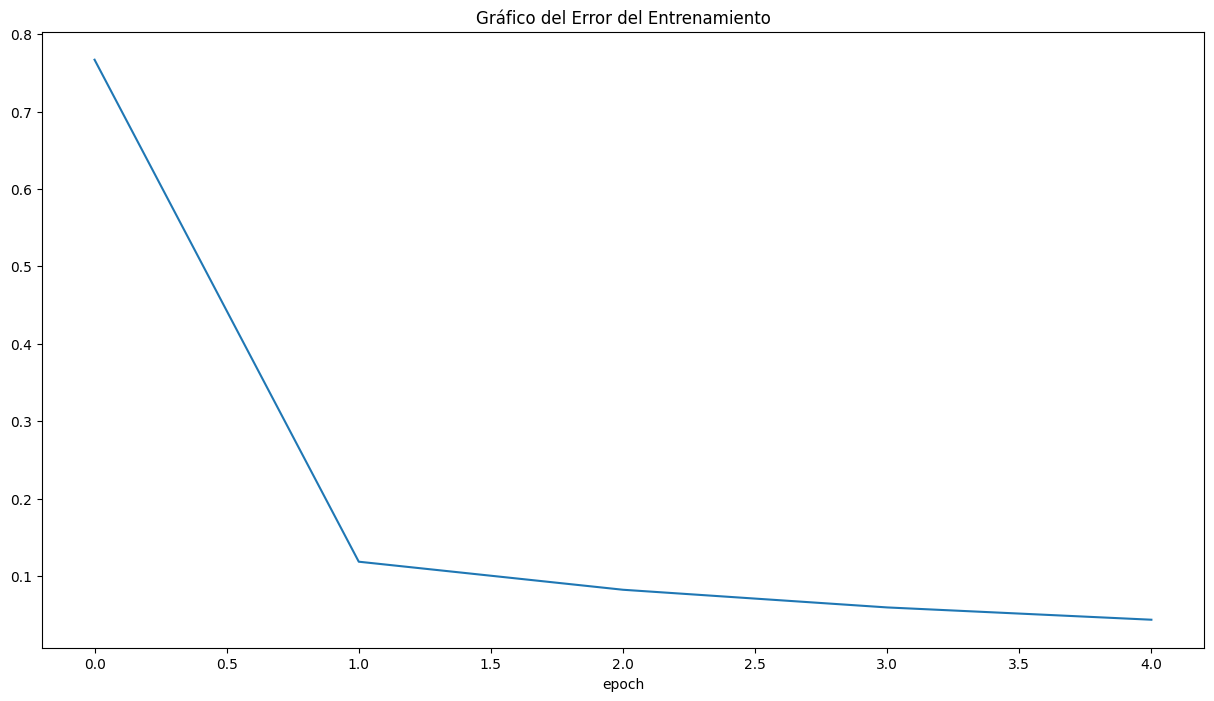

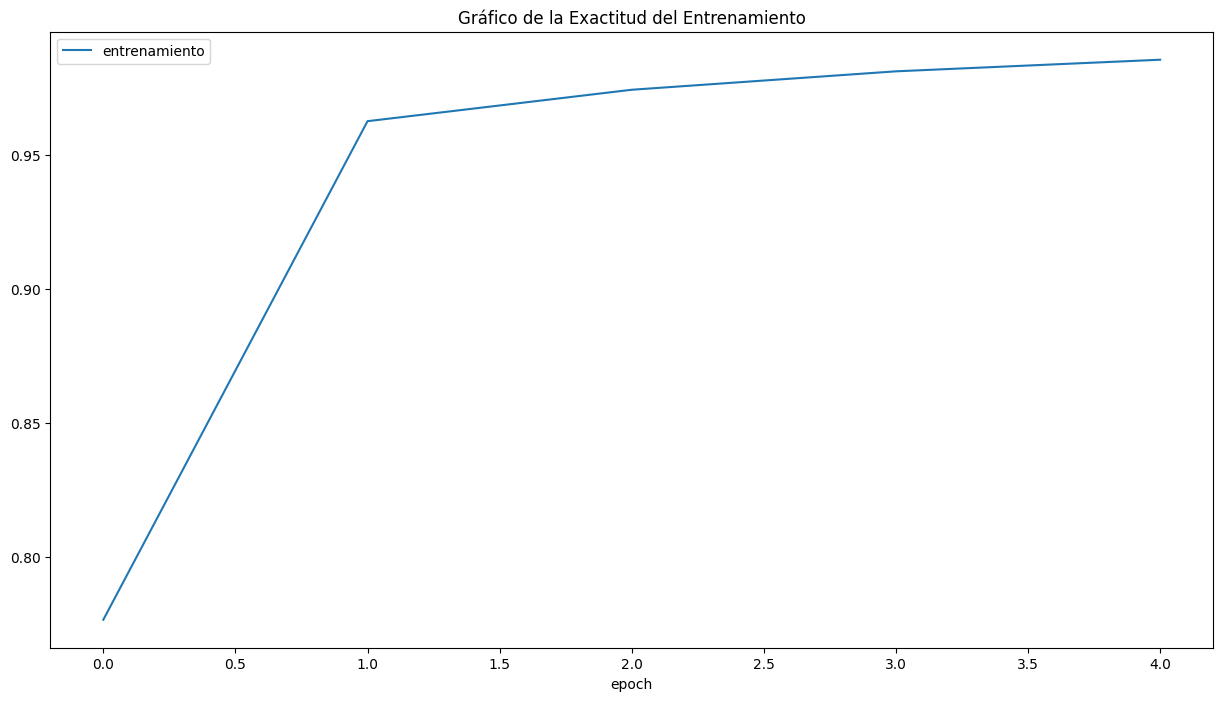

In [ ]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
if (tipoProblemaAplicar != "T"):
  plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
if (tipoProblemaAplicar != "T"):
  plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8))
if (tipoProblemaAplicar == "C") or (tipoProblemaAplicar == "T"):
  plt.plot(history.history['accuracy'])
  if (tipoProblemaAplicar != "T"):
    plt.plot(history.history['val_accuracy'])
  plt.title('Gráfico de la Exactitud del Entrenamiento')
elif (tipoProblemaAplicar == "E"):
  plt.plot(history.history['RootMeanSquaredError'])
  plt.plot(history.history['val_RootMeanSquaredError'])
  plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')

plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [ ]:
#@title Define clase auxiliar TextGenerator (sólo se usa cuando considerar_atributo_clase = "texto - GENERACION")

import joblib

class TextGenerator():

  def __init__(self, model, text_encoder, tagBegin, tagEnd, sepTokens=" "):
      self.model = model
      self.textEncoder = text_encoder
      self.y_vocab = np.array(text_encoder.get_vocabulary())
      self.tagBegin = tagBegin
      self.tagEnd = tagEnd
      self.sepTokens = sepTokens
      self.cantModelInputs = self.determinarCantModelInputs()

  def save(self, path, saveTextEncoder=False, saveModel = False):
      # guarda en variables auxiliares
      auxi_textEncoder = self.textEncoder
      auxi_model = self.model
      # guarda objeto
      fn = path+"/TextGenerator.joblib"
      self.textEncoder = None
      self.model = None
      joblib.dump(self, fn)
      self.textEncoder = auxi_textEncoder
      self.model = auxi_model
      print("\n-TextGenerator guardado en ", fn,"\n")
      if saveTextEncoder and (auxi_textEncoder is not None):
          fn = path+"/TextGenerator.TextEncoder_config"
          joblib.dump(
              {'config': auxi_textEncoder.get_config(),
             'weights': auxi_textEncoder.get_weights()}
            , fn)
          print("\n-TextGenerator.TextEncoder guardado en ", fn,"\n")
      if saveModel and (auxi_model is not None):
          fn = path+"/Model"
          auxi_model.save(fn)
          print("\n-TextGenerator.Model guardado en ", fn,"\n")

  @classmethod
  def load(cls, path, textEncoder=None, model=None):
      if textEncoder is None:
        fn = path+"/TextGenerator.TextEncoder_config"
        TE_disk = joblib.load(fn)
        textEncoder =  tf.keras.layers.TextVectorization.from_config(TE_disk['config'])
        textEncoder.set_weights(TE_disk['weights'])
      if model is None:
        fn = path+"/Model"
        model =  tf.keras.models.load_model(fn)
      # carga clase
      fn = path+"/TextGenerator.joblib"
      auxTG = joblib.dump(fn)
      auxTG.textEncoder = textEncoder
      auxTG.model = model
      return auxTG

  def determinarCantModelInputs(self):
      cantInputs = 0
      for layer in self.model.layers:
        if isinstance(layer, keras.layers.InputLayer):
          cantInputs = cantInputs + 1
      return cantInputs

  def samplePreds(self, preds, temperature):
      # función que se usa para generar mayor diversidad al generar texto
      # helper function to sample an index from a probability array
      preds = np.asarray(preds).astype("float64")
      if temperature > 0.0:
        preds = preds / temperature
      ##preds = np.log(preds) / temperature
      ##preds = np.nan_to_num(preds)
      exp_preds = np.exp(preds)
      preds = exp_preds / np.sum(exp_preds)
      probas = np.random.multinomial(1, preds, 1)
      return np.argmax(probas)

  def generar(self, datos=None, startText="", diversity=0.5):
      # prepara datos
      if (datos is None) or (len(datos)==0):
        input_x = None
        if self.cantModelInputs == 2:
          raise(Exception("No se ha indicado los datos complementarios!"))
          return None
      else:
        input_x = np.array( [ datos ] )
        input_x = np.array(input_x).astype(object)
      # prepara texto inicio
      input_text = self.tagBegin
      pos_sgte_input_text = 1
      if startText != "":
        input_text = input_text + self.sepTokens + startText
        y_texto = startText
      else:
        y_texto = ""
      # codifica texto de inicio
      input_textCodif = np.array( [ self.textEncoder(input_text) ] )
      # determina siguiente posición a usar
      if startText != "":
        for i in range(len(input_textCodif[0])):
          if input_textCodif[0][i] == 0:
            pos_sgte_input_text = i
            break
      # chequea temperatura
      if diversity <= 0.0:
        diversity = 0.001
      for _ in range(100):
        # ejecuta modelo
        if self.cantModelInputs == 2:
          y = self.model.predict( [ input_x,  input_textCodif ], verbose=0 )
        else:
          y = self.model.predict( input_textCodif, verbose=0 )
        # determina salida
        id = self.samplePreds(y[0], diversity)
        ##id = int( np.argmax(y[0], axis=0) )
        res = self.y_vocab[id]
        # contrala si tiene que termina
        if (id == 0) or (res == self.tagEnd):
            break
        # concatena texto de salida sólo si es caracter válido
        if checkValidCharacter(res):
          y_texto = y_texto + self.sepTokens + res
        else:
          print("-- se descarta caracter inválido: (", ord(res), ")")
          print("\t\t\t", res)
        # agrega salida para siguiente ejecución del modelo
        if pos_sgte_input_text >= len(input_textCodif[0]):
          return y_texto
        input_textCodif[0][pos_sgte_input_text] = id
        pos_sgte_input_text = pos_sgte_input_text + 1
      return y_texto

print("Clase TextGenerator definida.")

Clase TextGenerator definida.


In [ ]:
#@title Evaluar red entrenada con datos de entrenamiento

umbral_clasificacion = 50 # param {type:"slider", min:1, max:99, step:1}
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

def probarModelo_GenTextoEjemplos(gt, x, y, mostrarTodos=False):
  if mostrarTodos:
    # muestra varios (no todos porque sino tarda demasiado)
    cantTotal = len(y)
    tomalAlAzar = False
    posEj = 0
    print("    ( procesando todos los "+str(cantTotal)+" ejemplos )")
  else:
    # prueba con <cantMostrar> ejemplos
    cantTotal = 10
    tomalAlAzar = True
    print("    ( procesando "+str(cantTotal)+" ejemplos al azar )")
  if (x is None) or (len(x)==0):
    x = None
    input_datos = None
  auxStartText = ""
  for i in range(cantTotal):
    if tomalAlAzar:
      # toma al azar
      posEj = random.randint(1, len(y))-1
    else:
      # toma secuencial
      posEj = posEj + 1
    print("\n", i+1, ") Ejemplo ", posEj)
    if not(x is None):
      # ejecuta con datos
      input_datos = x[posEj]
      print("* Datos: ", input_datos )
    else:
      # ejecuta sin datos y pasando la primera palabra
      auxStartText = separarTexto(y[posEj], separadorTokens)[0]
    print("+ Texto Original: ", y[posEj] )
    if auxStartText != "":
      print("> se ingresa: ", auxStartText)
    # genera texto
    for diversityPreds in [0.1, 0.5, 1.0, 1.5, 2.0]:
      textoRes = gt.generar(datos=input_datos, startText=auxStartText, diversity=diversityPreds)
      print("- Texto Generado (diversity="+str(+diversityPreds)+"): ", textoRes )
    print("--------------------------------------------------------------")


# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

def prepararUI_GenTextoIngresado():
    global probar_startText, probar_diversity

    print("\n")

    # auxiliar para que muestre bien la descripción
    style_3D = {'description_width': 'initial'}

    # prepara campo para ingresar nombre clases (toma por defecto de config)
    probar_startText = widgets.Text(
        value='',
        placeholder='',
        description='Ingrese texto inicial:',
        style=style_3D,
        disabled=False
    )

    probar_diversity = widgets.FloatSlider(
        value=0.5,
        min=0.1,
        max=2.0,
        step=0.1,
        description='Diversity Temperature:',
        style=style_3D,
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )

    # prepara botón y grilla con objetos
    btnProbar = widgets.Button(
        description='Probar'
    )

    probarGentText_ui = widgets.GridBox(
          children=[probar_startText, probar_diversity, btnProbar],
          layout=Layout(width='100%')  )
    btnProbar.on_click(on_buttonProbar_clicked)

    # clear_output()
    out_probarGenText = widgets.interactive_output(hacerNada, {})
    display(probarGentText_ui)
    print("\n")

def on_buttonProbar_clicked(b):
  auxStartText = probar_startText.value
  divTemp = probar_diversity.value
  # inicializa y usa generador de texto
  textoRes = gt.generar(datos=None, startText=auxStartText, diversity=divTemp)
  print("> se ingresa: ", auxStartText)
  print("- Texto Generado: ", textoRes )
  print("--------------------------------------------------------------")

# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
 #   ax = fig.add_axes( [0, 0, 0.8, 0.8] )
 #   ax.boxplot( [arAbs, arRel] )
 #   ax.set_xticklabels( ["Error Absoluto", "Error Relativo"] )
#    plt.legend(["Error Absoluto", "Error Relativo"], loc='best')
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.5f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.5f} ± {:.5f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.5f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, umbralClas = 0.5, mostrarDetalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo -> Resultado")
      else:
        print(" Clase Real / Clase Modelo -> Resultado")

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ int(y[i]) ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = "  "
        if inclDatosEntrada:
          strTitulo = strTitulo + str(x[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) + ' [' + str(y[i]) + '] '
        strTitulo = strTitulo + ' / M: ' + str(clPred) + ' ' + str(predClass[i]) + ' '
        strTitulo = strTitulo + "-> " + ("OK" if (clPred==clReal) else "ERROR!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)


    # genera lista de labels
    labels_clases_map =  list(set(classReal + classPreds))
    labels_clases_map.sort()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=labels_clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in labels_clases_map],
        columns=['m:{:}'.format(x) for x in labels_clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    #cmtx.sort_index(axis=0, inplace=True)
    #cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels_clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
gt = None
if (tipoProblemaAplicar == "T"):
  # inicializa y usa generador de texto
  gt = TextGenerator(model, y_encoderLay, tag_gentext_begin, tag_gentext_end, separadorTokens)
  # prueba gen texto
  probarModelo_GenTextoEjemplos(gt, x_train, y_train, mostrar_detalle_entrenamiento)
  # prepara interface para ingresar otro texto
  # (se usa en la de prueba)
  ##prepararUI_GenTextoIngresado()
elif (tipoProblemaAplicar == "C"):
  # prueba clasificación
  probarModelo_Clasificacion(x_train, y_train, CLASES, mostrarDetalle=mostrar_detalle_entrenamiento)
else:
  # prueba estimación
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento)


*** Resultados con datos de Entrenamiento: 
    ( procesando 10 ejemplos al azar )

 1 ) Ejemplo  6748
* Datos:  Drama #!# 7.1 #!# 8 #!# Volver a lo mejor #!# Sobran mis palabras, pues no hay nada que no se haya dicho ya de esta película. Almodóvar vuelve con sus fuertes, "los personajes entrañables", la trama irreal y al mismo tiempo vital, los diálogos, su estética, su insuperable cámara y fotografía... en fin, mucho Almodóvar. Penélope hace el papel de su vida hasta la fecha, consigue emocionar. Carmen Maura como siempre, auténtica.
+ Texto Original:  Volver
- Texto Generado (diversity=0.1):   volver 
- Texto Generado (diversity=0.5):   volver 
- Texto Generado (diversity=1.0):   volver 
- Texto Generado (diversity=1.5):   volver 
- Texto Generado (diversity=2.0):   volver 
--------------------------------------------------------------

 2 ) Ejemplo  3158
* Datos:  Fantástico #!# 7.2 #!# 7 #!# La gravedad causa estragos #!# Esta peli me dolió en el alma, recordándome que la vida es 

In [ ]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = False #@param {type:"boolean"}

if (tipoProblemaAplicar != "T"):
  # evalua al modelo entrenado
  resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test), verbose=0)
  print("\n>Evaluación del Modelo: ")
  print("    - Error: ", round(resEval[0],3))
  if (tipoProblemaAplicar == "C"):
    print("    - Exactitud: ", round(resEval[1]*100,2))
  else:
    print("    - Distancia Media Cuadrática Mínima: ", round(resEval[1],3))

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if (tipoProblemaAplicar == "T"):
  if esArchivoDatos:
    # prueba gen texto con ejemplos de datos
    probarModelo_GenTextoEjemplos(gt, x_test, y_test, mostrar_detalle_prueba)
  else:
    # para archivo de textos
    # prepara interface para ingresar otro texto
    prepararUI_GenTextoIngresado()
elif (tipoProblemaAplicar == "C"):
  # prueba clasificación
  probarModelo_Clasificacion(x_test, y_test, CLASES, mostrarDetalle=mostrar_detalle_prueba)
else:
  # prueba estimación
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba)




*** Resultados con datos de Prueba: 
    ( procesando 10 ejemplos al azar )

 1 ) Ejemplo  444
* Datos:  Terror #!# 6.6 #!# 8 #!# Nunca unas anginas dieron tantos disgustos..... #!# Y me reía yo de la pobre chica que aparecía al final de aquel vídeo promocional en el que veíamos la reacción de los espectadores en Sitges...!!Después de una larga espera, ha llegado [Rec] y no ha decepcionado en absoluto; por hacer una [odiosa] comparación en términos terroríficos, "el Orfanato" concentraba la tensión/susto! puntualmente en un par de escenas muy bien conseguidas; en [Rec] se va arrastrando a lo largo de todo el metraje (o reportaje? ;D) por el que te tienes que dejar absorver hasta llegar a un clímax final en el que ME CAGUÉ, casi literalmente.Ahora bien, el gran handicap que presenta [Rec] es su formato (creo que bastante novedoso dentro del cine español) a lo "blair witch project", que busca impactar a través de su hiper-realismo y que, como comprobé que les pasó a unos cuantos en el 

In [ ]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/textoRNN'  #@param {type:"string"}


if guardar_modelo:

    import joblib
    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_model = path_modelo+"/model.keras"
    model.save(fn_model)
    print("\n-Modelo guardado en ", fn_model,"\n")


    if esArchivoDatos:
      # solo para archivo de datos
      fn_func = path_modelo+"/FUNC_PREP_DATOS_ENTRADA.joblib"
      joblib.dump(prepararDatosEntradaTexto, fn_func)
      print("\n-Función para preparar datos de entrada como texto guardado en ", fn_func,"\n")

    fn_func = path_modelo+"/FUNC_CODIFICAR_TEXTO.joblib"
    joblib.dump(codificarTexto, fn_func)
    print("\n-Función para codificar el texto de entrada guardado en ", fn_func,"\n")

    if (tipoProblemaAplicar == "T") and\
     ("gt" in locals()) and (gt is not None):
        gt.save(path_modelo,
                saveTextEncoder=True,
                saveModel=False)

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", fn_clases,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/textoRNN/model.keras 


-Función para preparar datos de entrada como texto guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/textoRNN/FUNC_PREP_DATOS_ENTRADA.joblib 


-Función para codificar el texto de entrada guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/textoRNN/FUNC_CODIFICAR_TEXTO.joblib 


-TextGenerator guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/textoRNN/TextGenerator.joblib 


-TextGenerator.TextEncoder guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/textoRNN/TextGenerator.TextEncoder_config 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/textoRNN/CLASES_MAP.txt 

